In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

Goal: Predict the final price of a home from explanatory variables (qualities in a house that owners may be looking for)

# Initial Data Exploration

## Salesprice Data Distribution

In [2]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Things to note:
* minimum price > 0 -> will not mess up our data
* mean > median -> right skewed

<Axes: xlabel='SalePrice', ylabel='Density'>

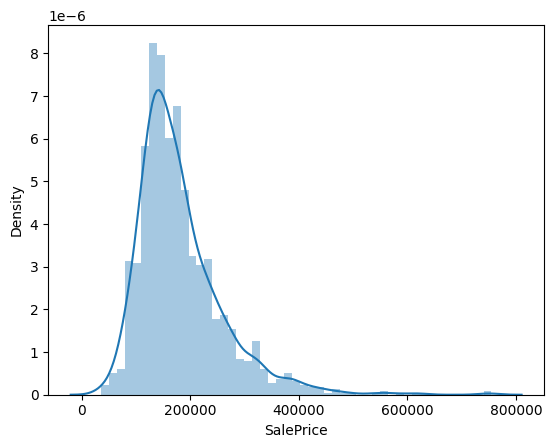

In [3]:
sns.distplot(df_train['SalePrice'])

More notes:
- distinct peak
- right skewed

<Axes: >

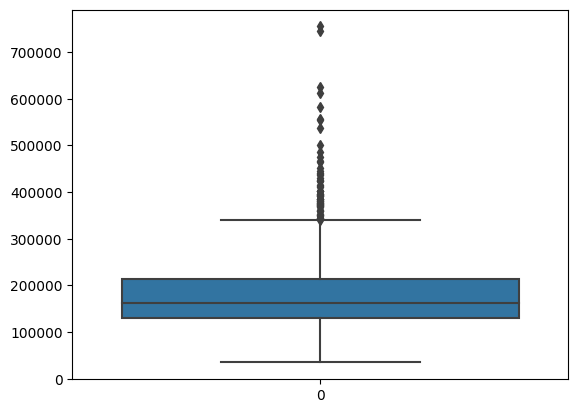

In [4]:
sns.boxplot(df_train['SalePrice'])

In [5]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


## Data Exploration

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
df_train.select_dtypes(include=['int64', 'float64']).describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Sales Price Relationship with Numeric Variables

In [8]:
# find all numeric columns
def get_num_columns(df):
    return df.select_dtypes(include='number').drop(columns=['Id'])
def get_cat_columns(df):
    return df.select_dtypes(exclude='number')

<Axes: >

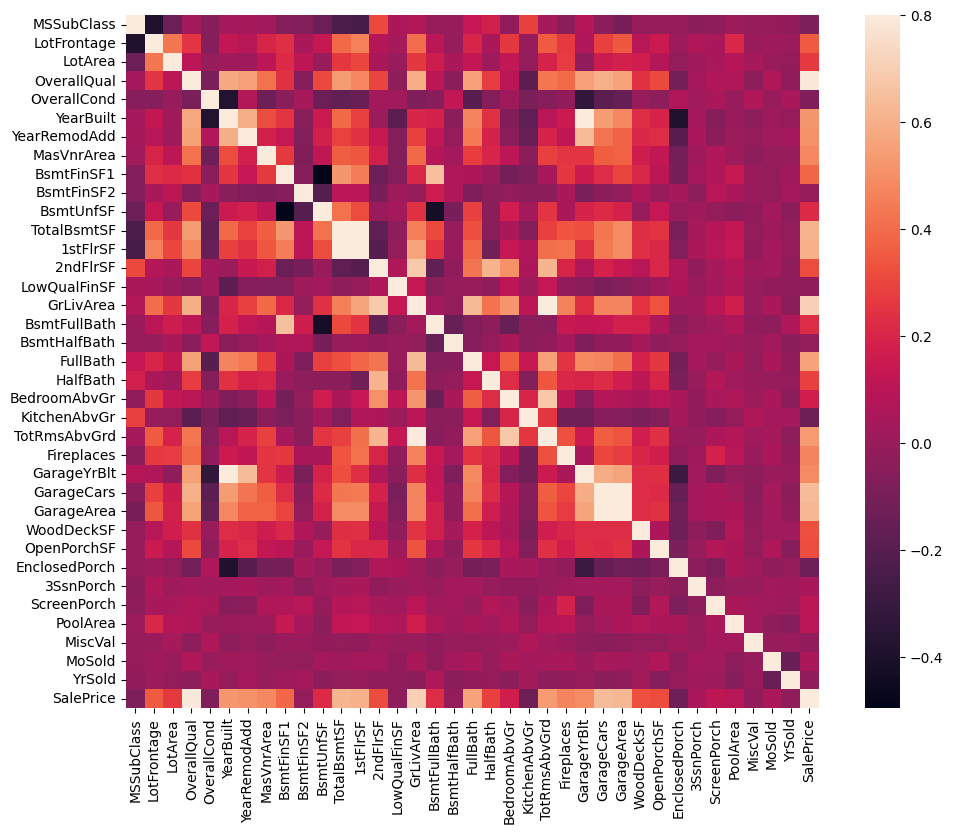

In [9]:
# More Relationship Analysis

#correlation matrix
corrmat = get_num_columns(df_train).corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

no extreme negative correlations

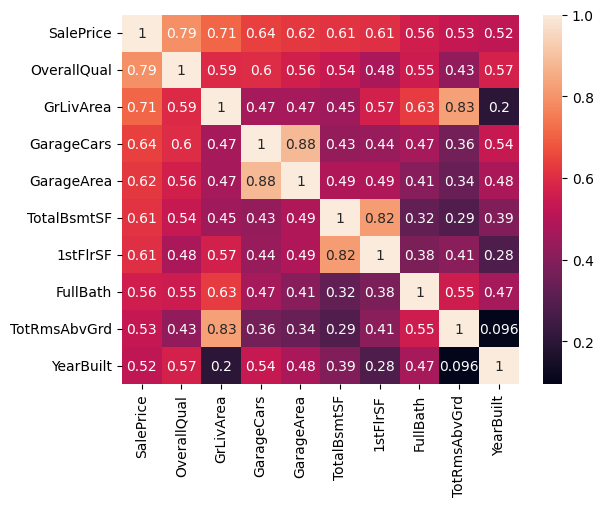

In [10]:
#saleprice correlation matrix
top10 = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[top10].values.T)
hm = sns.heatmap(cm, annot=True, yticklabels=top10.values, xticklabels=top10.values)
plt.show()

Notes: strong correlation between multiple variables, likely go hand in hand, only need to analyze one
- garage cars and garage area (keep garage cars)
- total basement sf and 1st floor sf (keep total basement sf)
- total rooms above ground and GrLivArea

Less correlation with year built, maybe do a time series? TODO

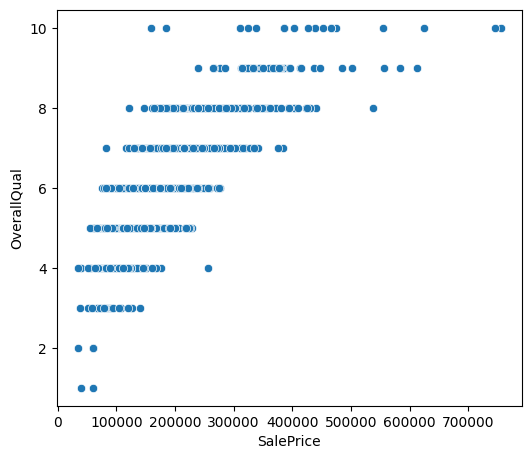

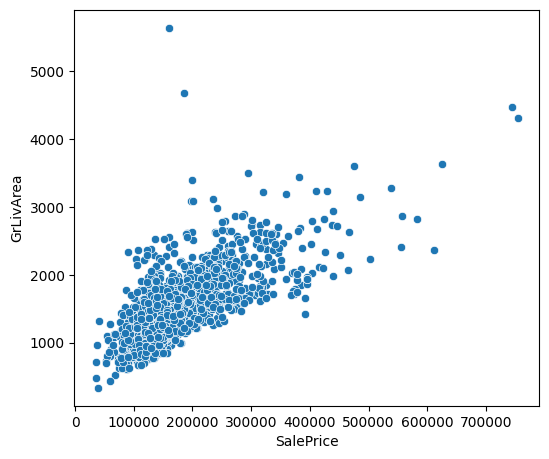

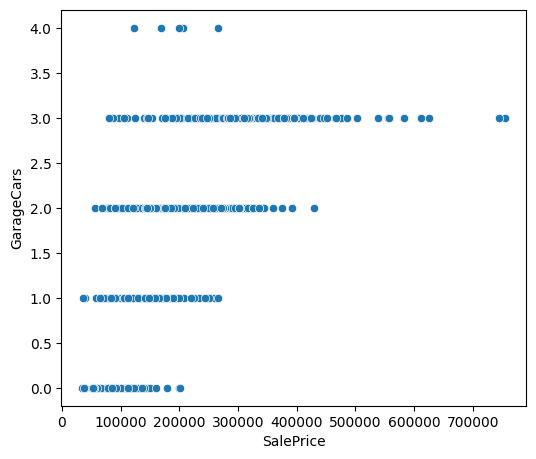

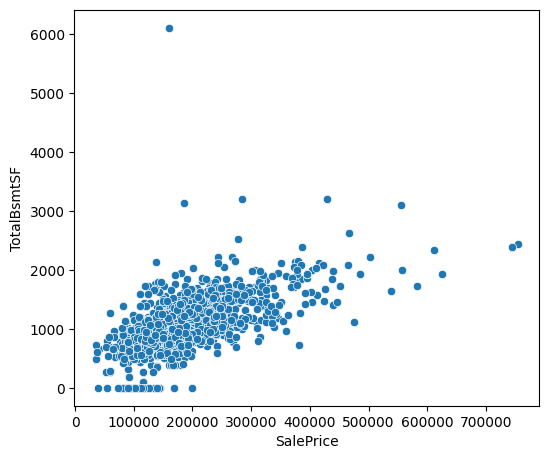

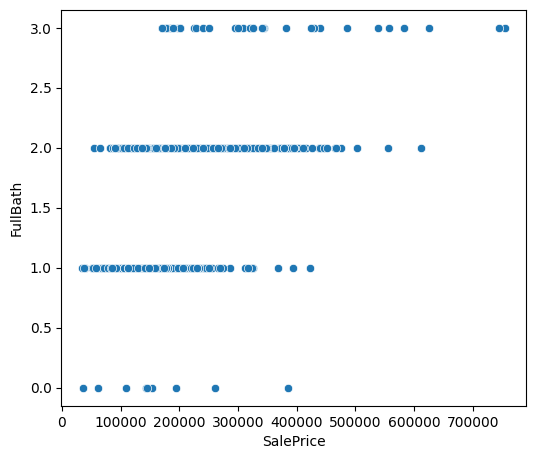

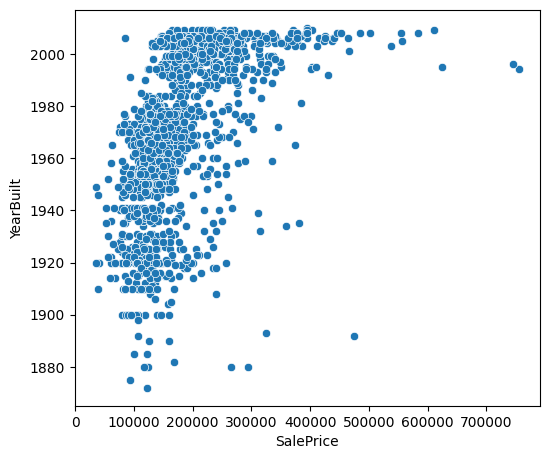

In [11]:
columns = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']

n = 0
for var in columns:
    n+=1
    plt.subplots(figsize = (6, 6*len(columns)))
    plt.subplot(len(columns), 1, n)
    sns.scatterplot(x='SalePrice', y=var, data=df_train)
    plt.show()

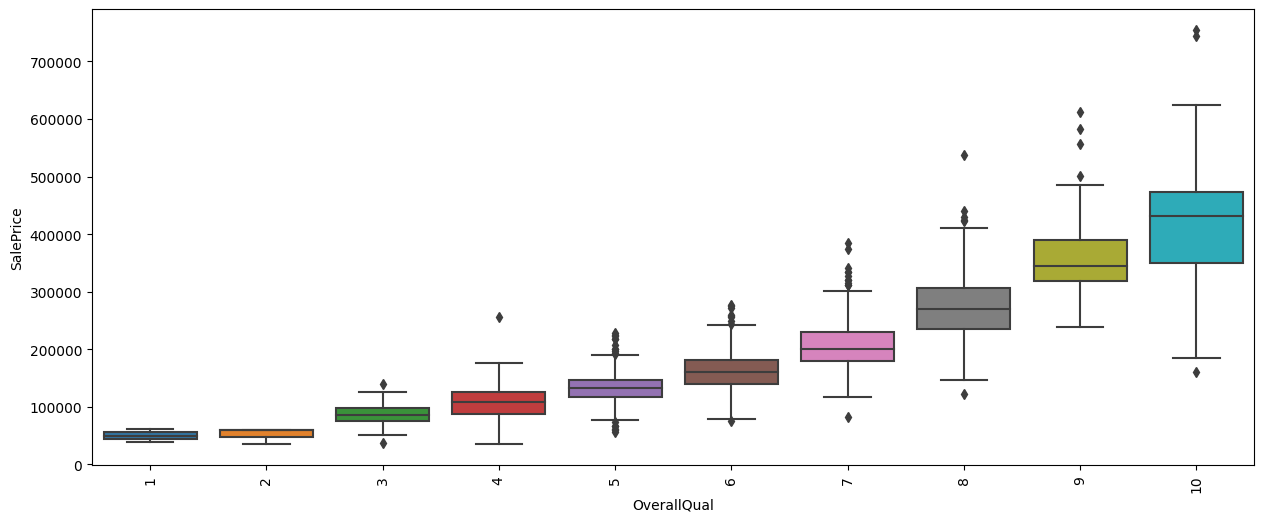

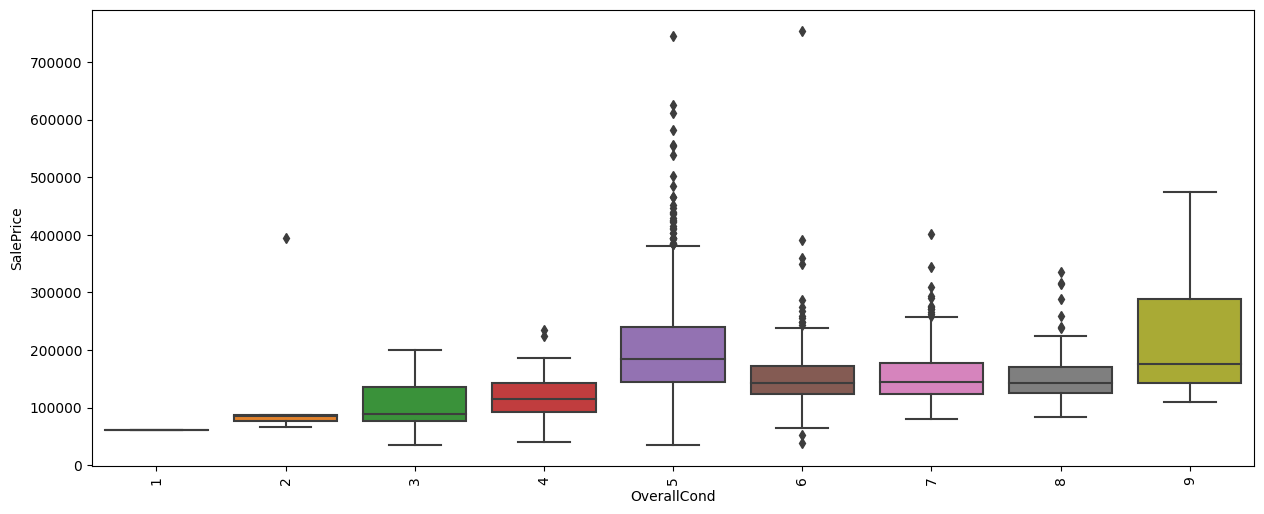

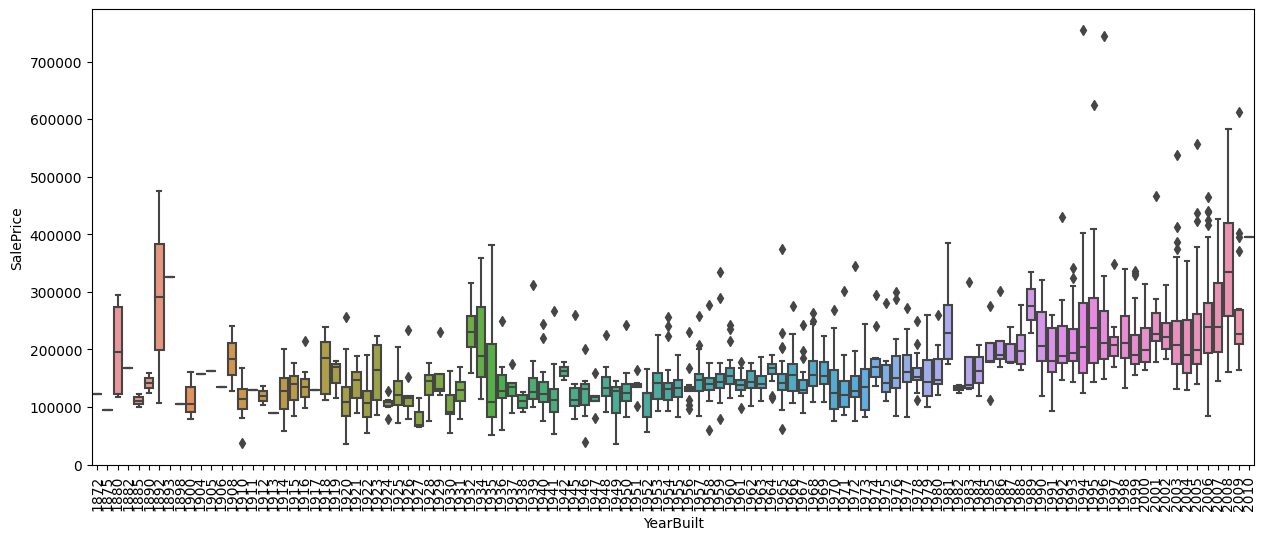

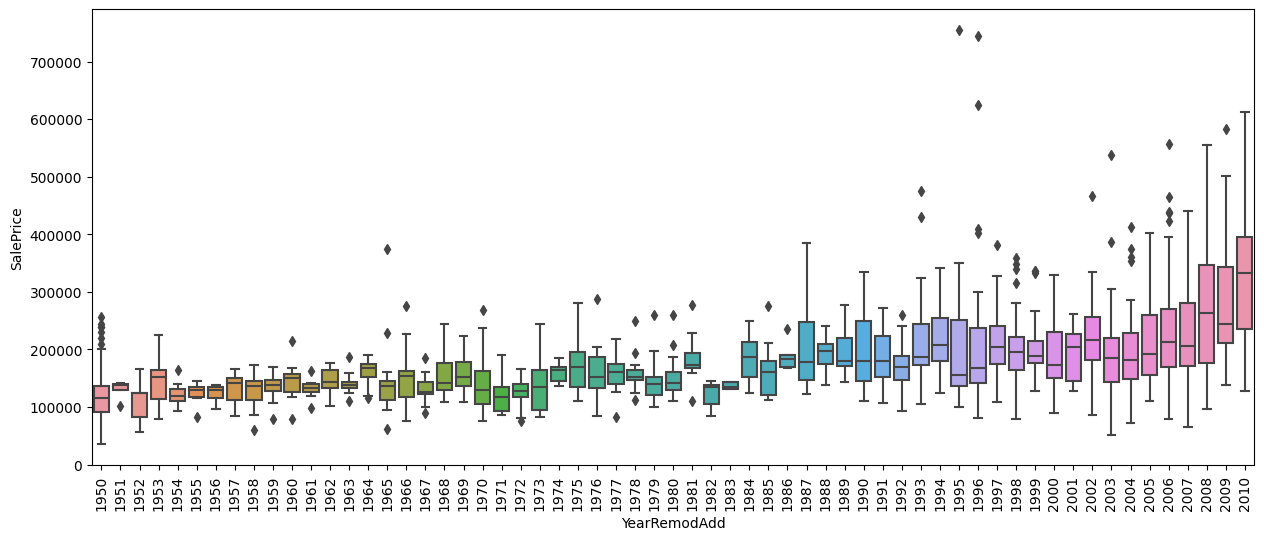

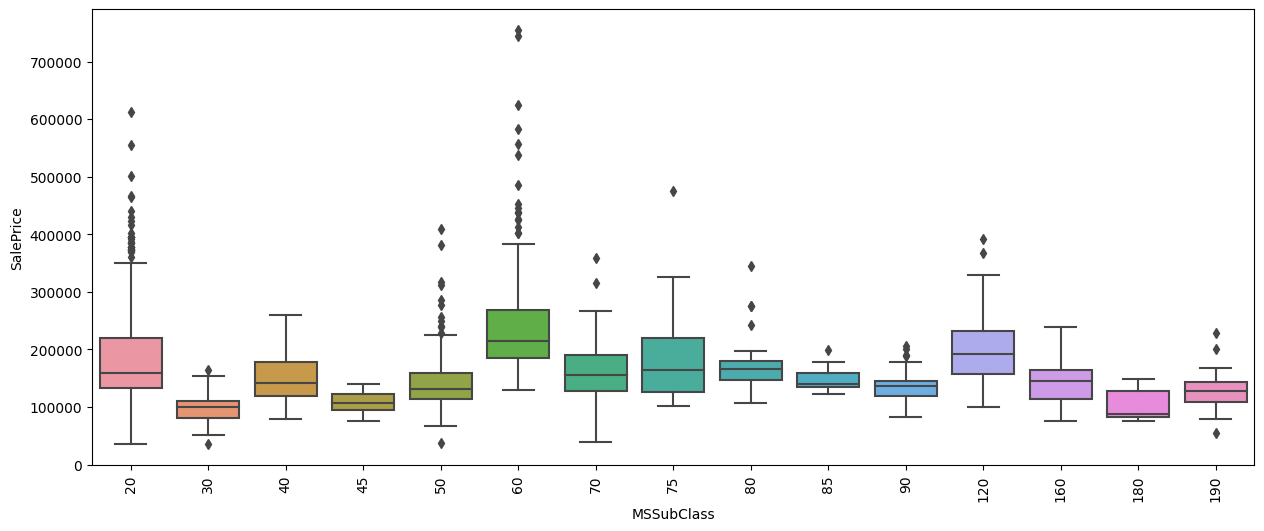

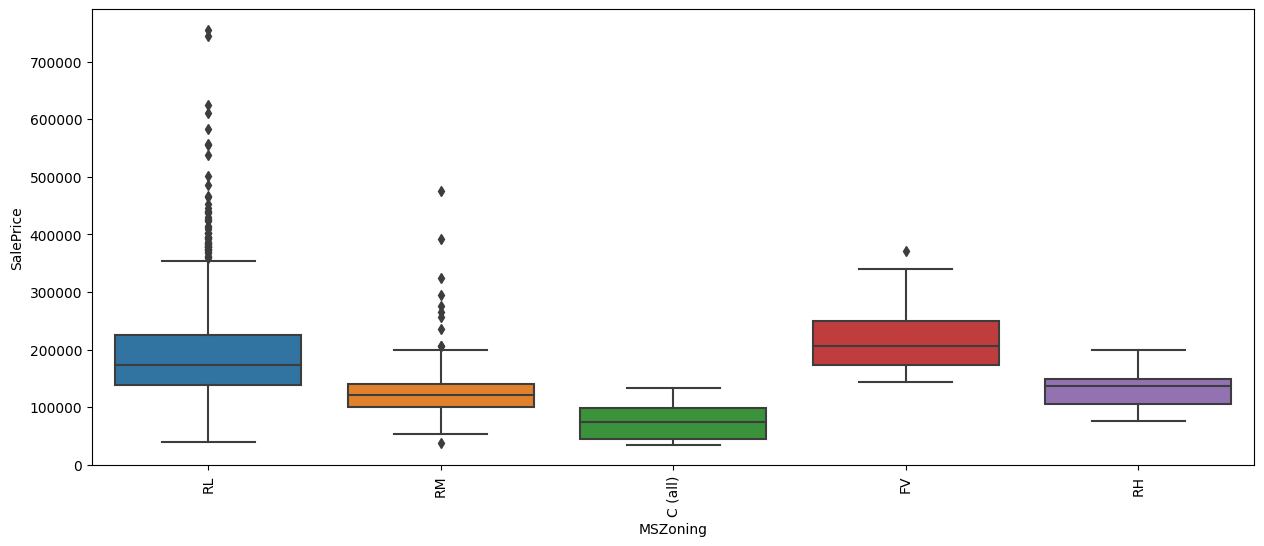

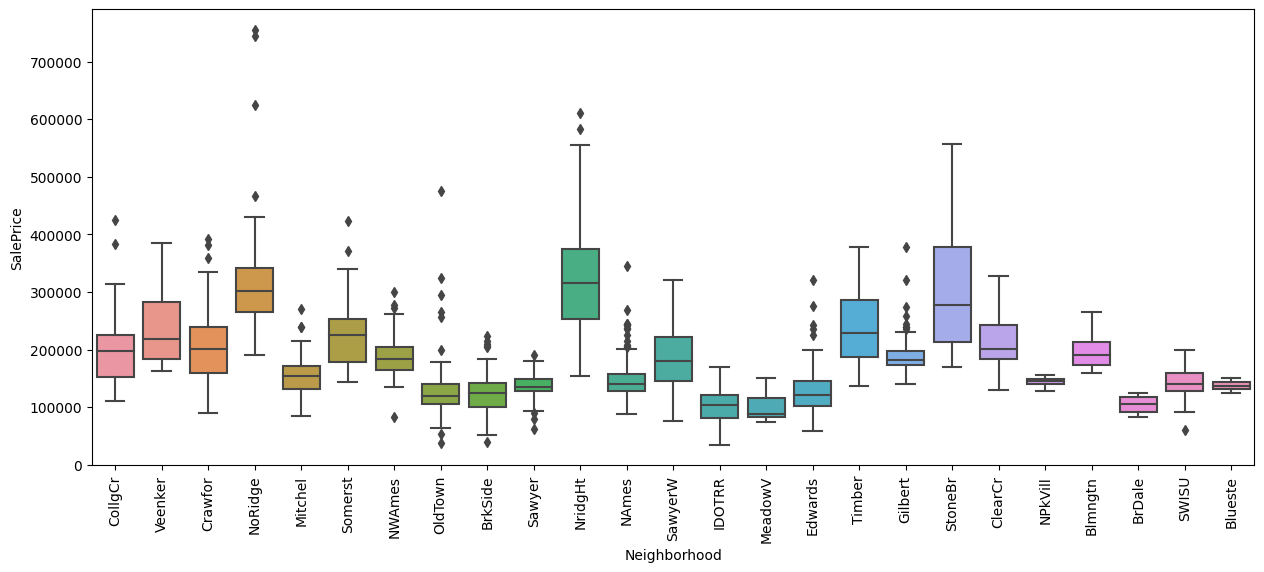

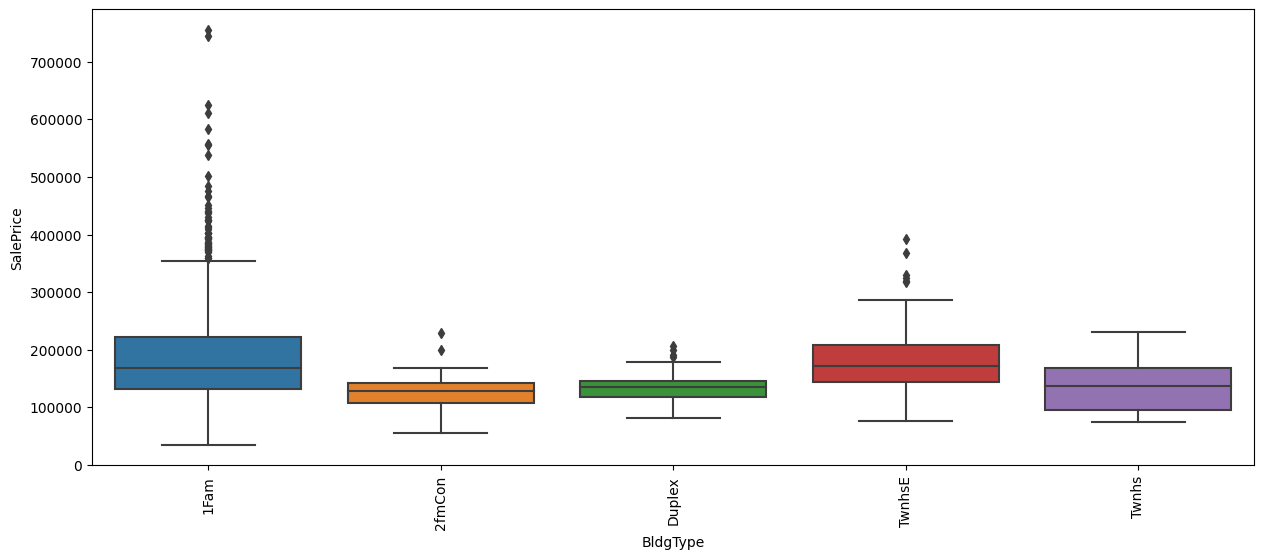

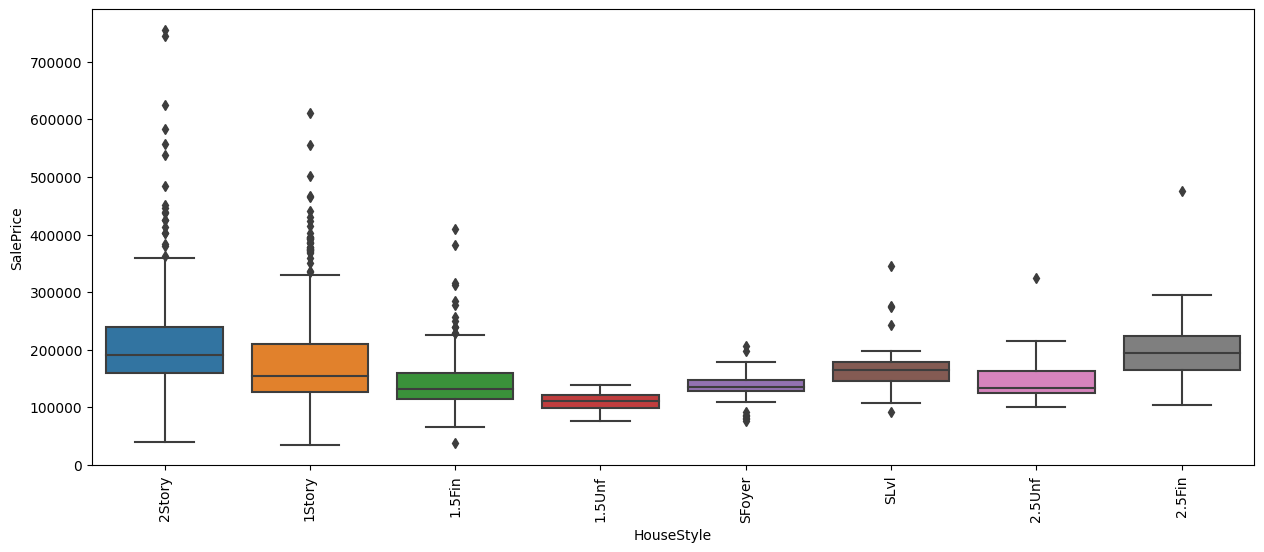

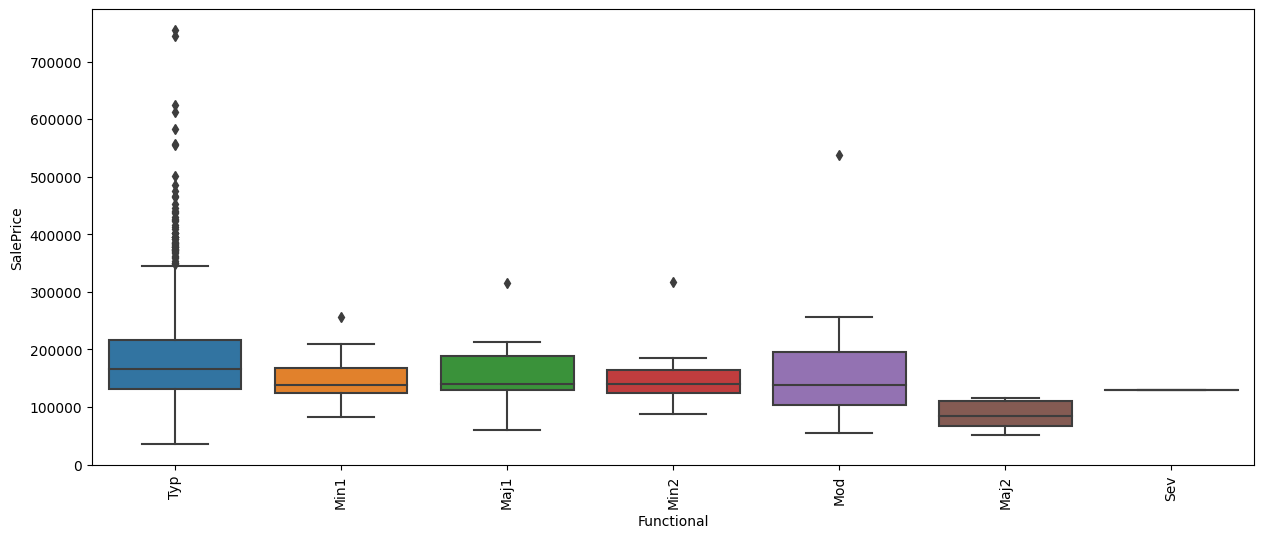

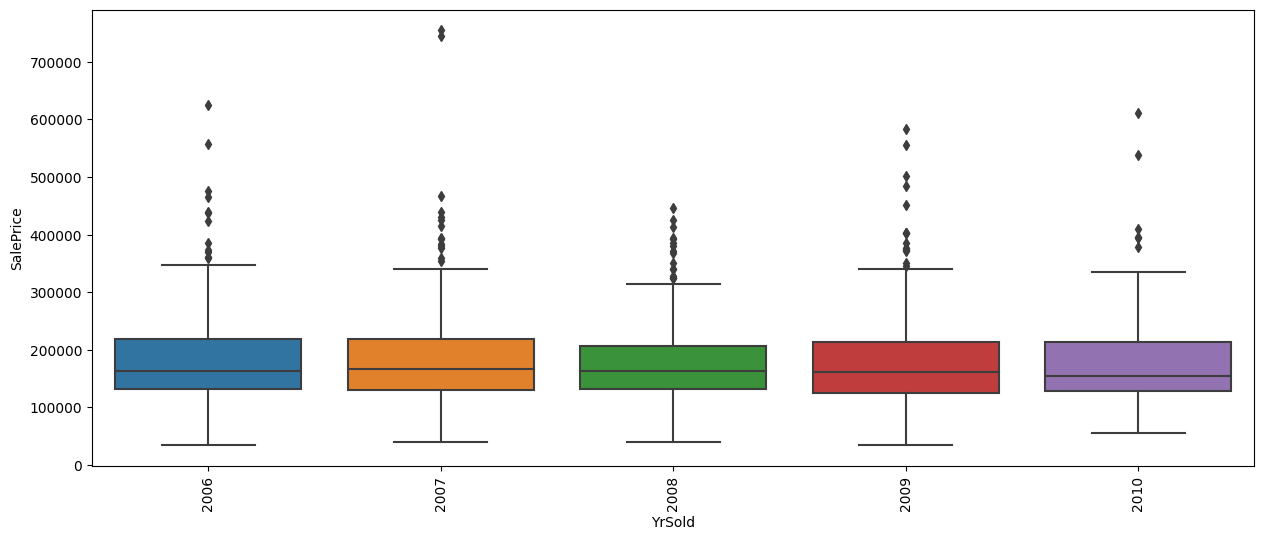

In [12]:
columns = ['OverallQual', 'OverallCond',
           'YearBuilt', 'YearRemodAdd',
           'MSSubClass', 'MSZoning', 
           'Neighborhood', 'BldgType', 'HouseStyle',
           'Functional',
           'YrSold'
          ]

n = 0
for var in columns:
    n+=1
    plt.subplots(figsize = (15, 7*len(columns)))
    plt.subplot(len(columns), 1, n)
    sns.boxplot(x=var, y='SalePrice', data=df_train)
    plt.xticks(rotation=90)
    plt.show()

### missing values

In [13]:
# calculate number of values and percent missing
def missing_data(df):
    total_null = df.isnull().sum().sort_values(ascending=False)
    percent_null = (total_null / len(df)).sort_values(ascending=False)

    return pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent']).head(20)

In [14]:
missing_data(df_train)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


In [15]:
# delete features that are missing more than 80% of data missing
df_train = df_train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

# drop garage variables with missing data since we can assume that 
# garage cars and garage area are the most important garage variables
df_train = df_train.drop(columns=['GarageYrBlt', 'GarageCond', 'GarageType', 'GarageFinish', 'GarageQual'])

# drop basement variables with missing data since we can assume that 
# basement square footage is the most important garage variable
df_train = df_train.drop(columns=['BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1'])

# fill missing electrical value with the mode value
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode)

# fill LotFrontage feet value with the average of lot frontage in specified neighborhood
df_train['LotFrontage'] = df_train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# df_clean['LotFrontage'] = df_clean['FireplaceQu'].fillna(None)

# fill non-intuitive missing values value with 'None'
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('None')
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna('None')
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('None')

missing_data(df_train)

# Some of the non-numeric predictors are stored as numbers; convert them into strings 
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)